## Example 5: A transmural fiber

_This example requires OpenCL-capable hardware, drivers, and an OpenCL SDK._

In this example we use the same model code as before but now for tissue simulations.

We will set up a transmural strand of cells, consisting of 60 endocardial, 45 mid-myocardial, and 60 epicardial cells.
As before, the cell type is set using the `cell.type` variable, but this time we supply a _scalar field_

To get closer to a stable situation, we simulate 3 beats and log only the 3d.

In [1]:
import myokit

# Load the model from a file
m = myokit.load_model('models/c/tentusscher-2006.mmt')

# Use a custom protocol
p = myokit.pacing.blocktrain(duration=3, period=400, offset=2)

# Set the tissue dimensions
n_end = 60
n_mid = 45
n_epi = 60
n = n_end + n_mid + n_epi

# Create a multi-cell simulation
s = myokit.SimulationOpenCL(m, p, ncells=n, precision=myokit.DOUBLE_PRECISION)

# Decide which cells to pace
s.set_paced_cells(3)

# Set the conductance value to obtain a realistic propagation time
g = 100
s.set_conductance(g)

# Double the stimulus amplitude
s.set_constant('stimulus.amplitude', m.get('stimulus.amplitude').eval() * 2)

# Set a step size (see below!)
s.set_step_size(0.002)

# Add a scalar field representing different cell types (0:endo, 1:epi, 2:mid)
types = [0] * n_end + [2] * n_mid + [1] * n_epi
s.set_field('cell.type', types)

Now we pre-pace. Because this can take a while, we pass in a `ProgressPrinter` that will provide us with some updates while the simulation runs. (Note that simulations run in the IDE will show a progress bar by default, so no printer is needed there!)

In [2]:
# Pre-pace for two beats
p = myokit.ProgressPrinter(digits=-1)
s.pre(800, progress=p)

[0.0 minutes] 0 % done
[0.3 minutes] 10 % done, estimated 2.7 minutes remaining
[0.6 minutes] 20 % done, estimated 2.3 minutes remaining
[0.9 minutes] 30 % done, estimated 2.0 minutes remaining
[1.2 minutes] 40 % done, estimated 1.7 minutes remaining
[1.4 minutes] 50 % done, estimated 1.4 minutes remaining
[1.7 minutes] 60 % done, estimated 1.2 minutes remaining
[2.0 minutes] 70 % done, estimated 52 seconds remaining
[2.3 minutes] 80 % done, estimated 34 seconds remaining
[2.5 minutes] 90 % done, estimated 17 seconds remaining
[2.8 minutes] 100 % done, estimated 0 seconds remaining


In [3]:
# Run logged simulation for two beats
p = myokit.ProgressPrinter(digits=-1)
d = s.run(800, log_interval=0.5, log=['engine.time', 'membrane.V'], progress=p)

# Calculate conduction velocity
b = d.block1d()
cv = b.cv('membrane.V', length=0.0025)
print(f'CV: {cv} cm/s')

[0.0 minutes] 0 % done
[0.3 minutes] 10 % done, estimated 2.7 minutes remaining
[0.6 minutes] 20 % done, estimated 2.3 minutes remaining
[0.9 minutes] 30 % done, estimated 2.1 minutes remaining
[1.2 minutes] 40 % done, estimated 1.8 minutes remaining
[1.5 minutes] 50 % done, estimated 1.5 minutes remaining
[1.8 minutes] 60 % done, estimated 1.2 minutes remaining
[2.1 minutes] 70 % done, estimated 54 seconds remaining
[2.4 minutes] 80 % done, estimated 36 seconds remaining
[2.7 minutes] 90 % done, estimated 18 seconds remaining
[3.0 minutes] 100 % done, estimated 0 seconds remaining
CV: 46.54965841617926 cm/s


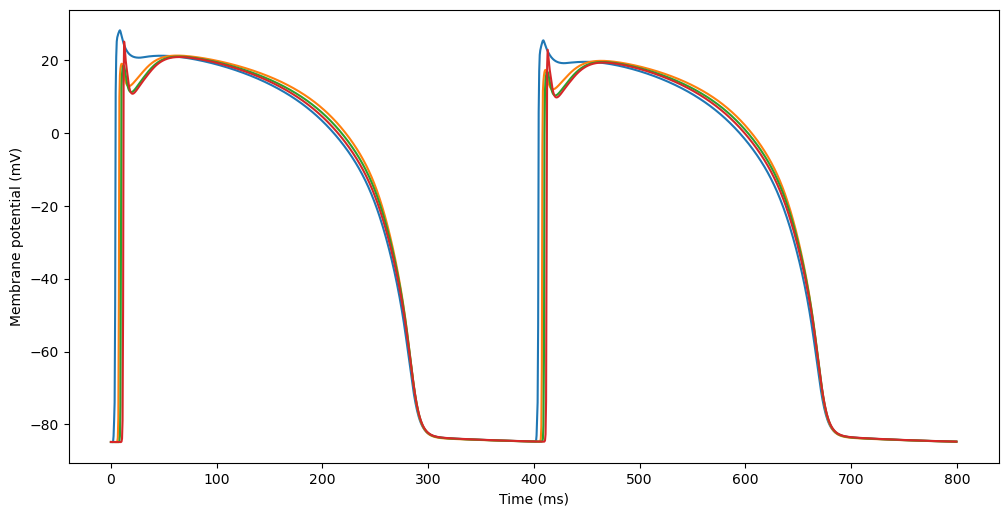

In [4]:
# Create quick plots of different cells' action potential
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6), dpi=100)
ax = fig.add_subplot()
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane potential (mV)')
for n in [15, 80, 115, 155]:
    ax.plot(d['engine.time'], d['membrane.V', n])
plt.show()

## Adapting a model for multi-cell simulations

Running multi-cell simulations requires the model equation for dV/dt to include a cell-to-cell _diffusion current_, with a value that will be supplied by the simulation engine.

For the ten Tusscher model, this looks roughly like this:

```
[membrane]
use stimulus.i_stim
dot(V) = -(i_ion + i_stim + i_diff)
    in [mV]
    label membrane_potential
i_ion = (+ ina.INa
         + ik1.IK1
         ...
        )
    in [A/F]
i_diff = 0 [A/F]
    in [A/F]
    bind diffusion_current
```

There are three critical bits here. First, V is updated using the sum of native transmembrane currents (`i_ion`), an experimental stimulus current `i_stim`, and a cell-to-cell current `i_diff`:
```
dot(V) = -(i_ion + i_stim + i_diff)
```

The value for `i_diff` will be calculated by the simulation engine, based on the `V` for this cell and its neighbours, and the cell-to-cell conductance.
To tell the simulation engine which variable to use for this diffusion current, we add a label (called a "binding" for inputs in Myokit) to our variable `i_diff`:
```
i_diff = 0 [A/F]
    in [A/F]
    bind diffusion_current
```

Finally, to calculate values for `i_diff`, the simulation engine needs to know which variable represents the membrane potential.
Again this is achieved with a label (called a "label" for outputs in Myokit):
```
dot(V) = -(i_ion + i_stim + i_diff)
    in [mV]
    label membrane_potential
```

There are additional complexities with running 2d simulations, some of which are briefly mentioned below.

## Setting the step size

Myokit's `Simulation` class uses the CVODE simulation engine that adaptively sets the step size to achieve results within some user-specified tolerance.
But the `SimulationOpenCL` class uses a simple fixed step size forward-Euler method.

What does this mean?

1. You'll need a basic understanding of how forward-Euler simulations work.
2. When setting up a simulation, you need to spend some time reducing and increasing the step size to see what happens. If your step size is small enough, further reductions of the step size won't change the result. If you get different results by reducing the step size, that means you haven't made it small enough and your simulation results are unreliable!
3. Always re-run important simulations with a halved step-size to see if it affects the result.

## Running without double precision

To increase spead and reduce the required memory, OpenCL simulations are often run in single precision.
This can cause some numerical issues to appear, that are usually hidden when running with double precision.
A common example occuring in this model is with equations like:

\begin{equation}
I_\text{CaL} = 4 \cdot g_\text{CaL} \cdot d \cdot f \cdot f_2 \cdot f_\text{Ca,SS} \cdot (V - 15) \frac{F^2}{R T} 
\frac{\frac{1}{4} Ca_\text{SS} \exp(2 (V - 15) \frac{F}{R T}) - Ca_o}{\exp(2 (V - 15) \frac{F}{R T}) - 1}
\end{equation}

and in particular the terms
\begin{equation}
(V - 15) \frac{\frac{1}{4} Ca_\text{SS} \exp(2 (V - 15) \frac{F}{R T}) - Ca_o}{\exp(2 (V - 15) \frac{F}{R T}) - 1}
\end{equation}

here, if $V = 15$ the denominator $\exp(2 (V - 15) \frac{F}{R T}) - 1$ can become zero, causing a divide-by-zero error.

With double precision, there is no reason that $V$ can't be exactly 15, but the added precision makes this quite unlikely.
With single precision, especially with multiple cells and over longer periods of time, it is quite likely that at some point $V$ will be close enough to 15 to cause trouble.

One way to fix this, is to rewrite the above equation as `ICaL = if(abs(V - 15) > 1e-6, original_equation, other_equation)`, where `other_equation` is derived using [l'Hopital's rule](https://en.wikipedia.org/wiki/L%27H%C3%B4pital%27s_rule).

It's possible to [automate this process](https://wellcomeopenresearch.org/articles/6-261), but this has not yet been [added to Myokit](https://github.com/myokit/myokit/issues/809).